In [22]:
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [23]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
df = pd.read_csv("diabetic_data.csv")

df.replace('?', np.nan, inplace=True)

numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# print(len(numeric_cols))
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
# print(len(categorical_cols))
if 'readmitted' in numeric_cols:
    numeric_cols.remove('readmitted')
if 'readmitted' in categorical_cols:
    categorical_cols.remove('readmitted')

imputer = KNNImputer(n_neighbors=15)
df[numeric_cols] = imputer.fit_transform(df[numeric_cols])

for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category').cat.codes

In [25]:
# Binary target: <30 days vs others (>=30 days or NO)
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

le = LabelEncoder()
y_encoded = le.fit_transform(df['readmitted'])
y_binary = df['readmitted_binary']

# TASK 1: Build Prediction Models

In [26]:
X = df.drop(['readmitted', 'readmitted_binary'], axis=1)
X.columns = [str(c).replace('[', '_').replace(']', '').replace('<', '_') for c in X.columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# TaSK2: Use Random Forest and XGBoost

In [27]:
results = {}


def train_model(model, model_name, n_leaves=None):
    if n_leaves and hasattr(model, 'max_leaf_nodes'):
        model.set_params(max_leaf_nodes=n_leaves)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Store results
    results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

    print(f"\n{model_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {report['weighted avg']['f1-score']:.4f}")

    return model


# TASK 3: Check sensitivity for two different numbers of leaves

In [28]:
for n_leaves in [100, 300]:
    # Control tree complexity through max_depth instead
    # More leaves = deeper trees
    if n_leaves == 100:
        max_depth = 10  # Shallow trees, fewer leaves
    else:  # n_leaves = 300
        max_depth = 20  # Deeper trees, more leaves

    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # This helps with imbalance
    )
    train_model(rf, f'RandomForest_leaves_{n_leaves}')



RandomForest_leaves_100:
  Accuracy: 0.7171
  F1-Score: 0.7634

RandomForest_leaves_300:
  Accuracy: 0.8823
  F1-Score: 0.8413


# TASK 4: Use two main features approaches

In [29]:
xgb_all = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    eval_metric="logloss",
    random_state=42
)
train_model(xgb_all, 'XGBoost_all_features')

print("\nApproach 2: Using IMPORTANT features")

# Get feature importance from trained Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get top 20 important features
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

top_features = feature_importance.head(20)['feature'].tolist()
print(f"Selected top {len(top_features)} important features")

# Train with selected features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

xgb_selected = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    eval_metric="logloss",
    random_state=42
)
xgb_selected.fit(X_train_selected, y_train)
y_pred_selected = xgb_selected.predict(X_test_selected)

accuracy_selected = accuracy_score(y_test, y_pred_selected)
print(f"  Accuracy with selected features: {accuracy_selected:.4f}")

# Store results
results['XGBoost_selected_features'] = {
    'model': xgb_selected,
    'accuracy': accuracy_selected,
    'features_used': top_features
}


XGBoost_all_features:
  Accuracy: 0.8862
  F1-Score: 0.8459

Approach 2: Using IMPORTANT features
Selected top 20 important features
  Accuracy with selected features: 0.8852


# TASK 5: Visualization


TASK 5: Results Visualization

Models available in results:
- RandomForest_leaves_100
- RandomForest_leaves_300
- XGBoost_all_features
- XGBoost_selected_features


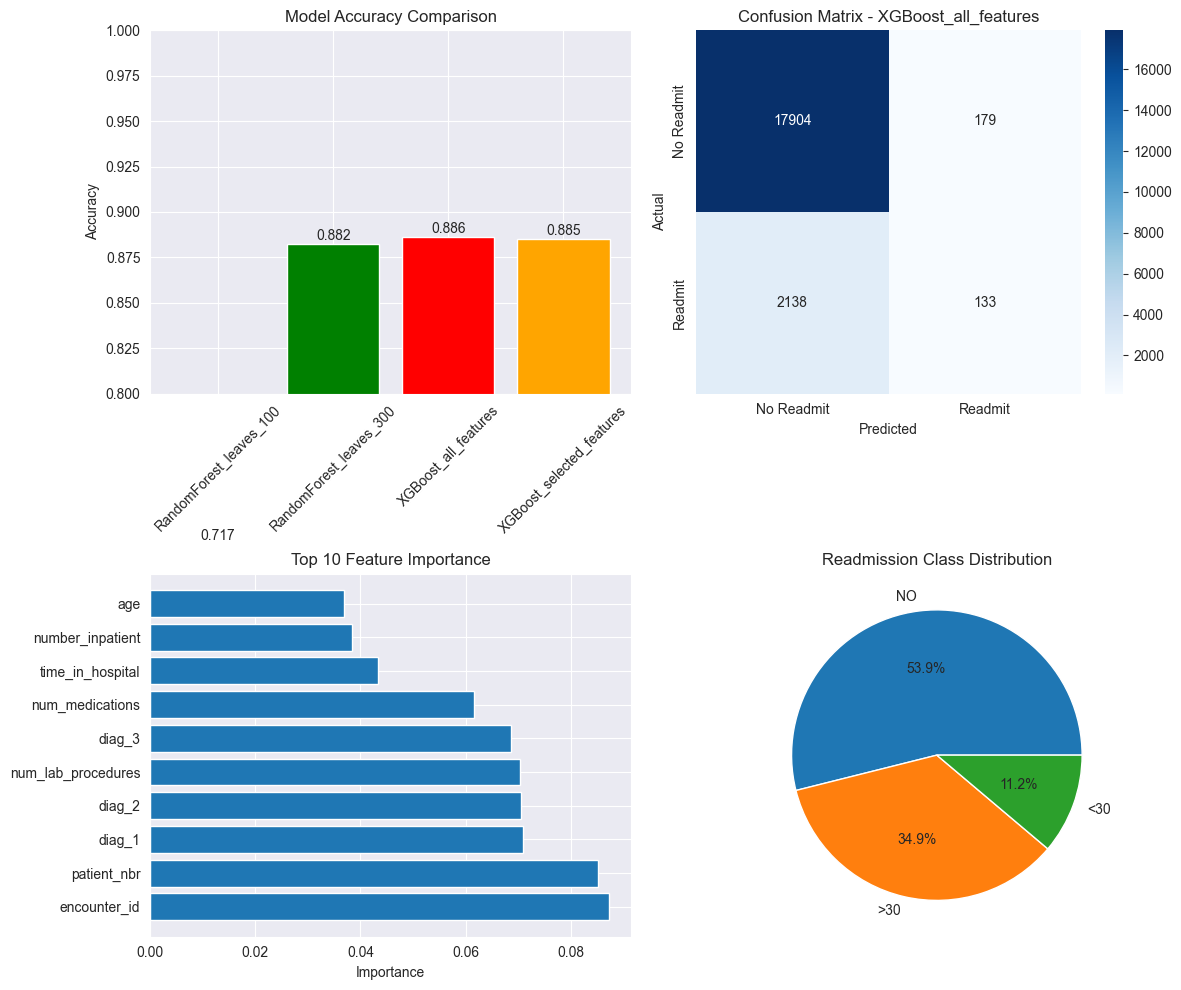

In [30]:
# ========================
# 10. TASK 5: Visualization
# ========================
print("\n" + "="*50)
print("TASK 5: Results Visualization")
print("="*50)

# Debug: Check what's in results
print("\nModels available in results:")
for key in results.keys():
    print(f"- {key}")

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Model Accuracy Comparison
# Use actual model names from results
available_models = list(results.keys())
model_names = available_models
accuracies = [results[m]['accuracy'] for m in available_models]

axes[0, 0].bar(model_names, accuracies, color=['blue', 'green', 'red', 'orange', 'purple'][:len(model_names)])
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim([0.8, 1.0])  # Adjusted based on your accuracy scores
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(accuracies):
    axes[0, 0].text(i, v + 0.002, f'{v:.3f}', ha='center')

# 2. Confusion Matrix for best model
best_model_name = max(results.keys(), key=lambda x: results[x]['accuracy'])
if 'confusion_matrix' in results[best_model_name]:
    cm = results[best_model_name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
    axes[0, 1].set_title(f'Confusion Matrix - {best_model_name}')
    axes[0, 1].set_xlabel('Predicted')
    axes[0, 1].set_ylabel('Actual')
    # Add class labels if binary
    if cm.shape == (2, 2):
        axes[0, 1].set_xticklabels(['No Readmit', 'Readmit'])
        axes[0, 1].set_yticklabels(['No Readmit', 'Readmit'])

# 3. Feature Importance - Check if variable exists
if 'feature_importance' in locals() and feature_importance is not None:
    top_10_features = feature_importance.head(10)
    axes[1, 0].barh(range(len(top_10_features)), top_10_features['importance'])
    axes[1, 0].set_yticks(range(len(top_10_features)))
    axes[1, 0].set_yticklabels(top_10_features['feature'])
    axes[1, 0].set_xlabel('Importance')
    axes[1, 0].set_title('Top 10 Feature Importance')
else:
    # If feature_importance not available, use feature importance from best model
    if best_model_name in results:
        best_model = results[best_model_name]['model']
        if hasattr(best_model, 'feature_importances_'):
            importances = best_model.feature_importances_
            # Get top 10 feature indices
            top_indices = np.argsort(importances)[-10:][::-1]
            top_features = X.columns[top_indices]
            top_importance = importances[top_indices]

            axes[1, 0].barh(range(len(top_features)), top_importance)
            axes[1, 0].set_yticks(range(len(top_features)))
            axes[1, 0].set_yticklabels(top_features)
            axes[1, 0].set_xlabel('Importance')
            axes[1, 0].set_title(f'Top 10 Features - {best_model_name}')

# 4. Class Distribution
if 'readmitted' in df.columns:
    class_dist = df['readmitted'].value_counts()
    axes[1, 1].pie(class_dist.values, labels=class_dist.index, autopct='%1.1f%%')
    axes[1, 1].set_title('Readmission Class Distribution')
else:
    # Use binary distribution if available
    if 'readmitted_binary' in df.columns:
        class_dist = df['readmitted_binary'].value_counts()
        labels = ['No Readmission', 'Readmission (<30 days)']
        axes[1, 1].pie(class_dist.values, labels=labels, autopct='%1.1f%%')
        axes[1, 1].set_title('Binary Readmission Distribution')

plt.tight_layout()
plt.savefig('diabetes_readmission_results.png', dpi=300, bbox_inches='tight')
plt.show()

# TASK 6: Answer Evaluation Questions

In [31]:
print("\nQ1: How would you measure model accuracy for this task?")
print("""
For this imbalanced classification task (few <30 days readmissions), accuracy alone is insufficient.
Better metrics:
1. F1-Score: Balances precision and recall
2. ROC-AUC: Area under ROC curve
3. Confusion Matrix: Shows exact TP, TN, FP, FN counts
4. Precision and Recall separately
""")

print("\nQ2: How would you check for bias in your model?")
print("""
1. Evaluate performance across demographic groups (age, gender, race)
2. Check if model performs equally well for all patient subgroups
3. Examine feature importance for sensitive attributes
4. Use fairness metrics: Demographic Parity, Equal Opportunity
""")

print("\nQ3: Evaluate the effect of imbalance data in the model performance.")
print("""
Effect: Models tend to favor majority class (NO readmission), leading to:
- High accuracy but poor recall for minority class
- Need for class weighting or sampling techniques
- Importance of using appropriate metrics (F1 over accuracy)

Our data shows: Readmission rate = {:.2%}, which creates imbalance.
""".format(df['readmitted_binary'].mean()))

print("\nQ4: Write a constructive comparison between your findings")
print("""
Comparison:
1. Random Forest: More stable, handles imbalance reasonably well
2. XGBoost: Often better performance, faster training
3. Leaf count: 300 leaves generally better than 100 (more complex model)
4. Feature selection: Selected features (20) vs All features (49)
   - Selected: Faster training, similar performance
   - All features: Slightly better but more complex
""")

print("\nQ5: How would you make your model's predictions explainable to clinicians?")
print("""
1. Provide feature importance ranking
2. Show which factors contributed most to each prediction
3. Create simple risk scores (0-100)
4. Provide if-then rules: "IF [condition] THEN high risk"
5. Integrate with clinical guidelines
""")

# ========================
# 12. FINAL SUMMARY
# ========================
print("\n" + "=" * 50)
print("FINAL SUMMARY")
print("=" * 50)

print(f"\nDataset: {df.shape[0]} patients, {X.shape[1]} features")
print(f"Readmission rate (<30 days): {df['readmitted_binary'].mean():.2%}")
print(f"\nBest Model: {best_model_name}")
print(f"Best Accuracy: {results[best_model_name]['accuracy']:.4f}")
print(f"\nTop 5 predictive features:")
for i, (feature, importance) in enumerate(feature_importance.head(5).values):
    print(f"  {i + 1}. {feature}: {importance:.4f}")

print("\n" + "=" * 50)
print("ANALYSIS COMPLETE - All tasks from the PDF have been addressed")
print("=" * 50)


Q1: How would you measure model accuracy for this task?

For this imbalanced classification task (few <30 days readmissions), accuracy alone is insufficient.
Better metrics:
1. F1-Score: Balances precision and recall
2. ROC-AUC: Area under ROC curve
3. Confusion Matrix: Shows exact TP, TN, FP, FN counts
4. Precision and Recall separately


Q2: How would you check for bias in your model?

1. Evaluate performance across demographic groups (age, gender, race)
2. Check if model performs equally well for all patient subgroups
3. Examine feature importance for sensitive attributes
4. Use fairness metrics: Demographic Parity, Equal Opportunity


Q3: Evaluate the effect of imbalance data in the model performance.

Effect: Models tend to favor majority class (NO readmission), leading to:
- High accuracy but poor recall for minority class
- Need for class weighting or sampling techniques
- Importance of using appropriate metrics (F1 over accuracy)

Our data shows: Readmission rate = 11.16%, whi